### Roman Imaging WCS

#### Generalized World Coordinate System (GWCS) Overview

Roman and JWST use the [GWCS](https://gwcs.readthedocs.io/en/latest/) for managing the World Coordinate System WCS). We call "WCS" the mapping from "pixel" coordinates to some "real-world" physical coordinates - celestial, spectral, time, etc. GWCS is a generalized implementation of WCS aiming to avoid the limitations of the FITS WCS standard. It is a flexible toolkit for expressing and evaluating transformations between pixel and world coordinates, as well as intermediate coordinates. The GWCS object supports a data model which includes the entire transformation pipeline from input pixel coordinates to world coordinates (and vice versa). 

GWCS is based on astropy and supports the [Shared Interface for WCS](https://github.com/astropy/astropy-APEs/blob/main/APE14.rst). The WCS "pipeline" is a list of steps, where each step is a tuple of coordinate frame and a transform to the next frame. The transform in the last step is `None` representing the final coordinate frame of the WCS pipeline.

Transforms are based on [astropy.modeling](https://docs.astropy.org/en/stable/modeling/) and include support for [coordinate units](https://docs.astropy.org/en/stable/units/index.html). Coordinate frames utilize [astropy.coordinates](https://docs.astropy.org/en/stable/coordinates/index.html). 
The GWCS object is serialized to [ASDF](https://asdf-standard.readthedocs.io/en/latest/) using the ASDF [WCS](https://asdf-wcs-schemas.readthedocs.io/en/latest/) and [transforms](https://asdf-transform-schemas.readthedocs.io/en/latest/) extensions.

Download a Roman Level2 simulated file. The downloaded file is called `r002_assign_wcs.asdf`.

#### Roman Imaging WCS

The `assign_wcs` step in the Roman calibration pipeline constructs a WCS object and assigns it to the Level 2 image. The distortion transformations are stored in a reference file in CRDS, with `reftype=distortion`. The distortion includes all transformsations from a detector to a coordinate frame associated with the telescope `(V2, V3)`. The telescope telemetry is used to transform from `(V2, V3)` to celestial coordinates.



We can use `asdf` or `roman_datamodels` to open the file and retrieve the WCS object.

In [1]:
from roman_datamodels import datamodels as rdm

In [2]:
image = rdm.open('../data/r0000101001001001001_01101_0001_WFI01_cal.asdf')
image.search('wcs')

/Users/dencheva/opt/anaconda3/envs/romanrelease/lib/python3.11/site-packages/asdf/_asdf.py:354: AsdfWarning: File 'file:///Users/dencheva/dev/roman-data-workshop/data/r0000101001001001001_01101_0001_WFI01_cal.asdf' was created with extension URI 'asdf://astropy.org/core/extensions/core-1.5.0' (from package asdf-astropy==0.5.0), which is not currently installed
  warnings.warn(msg, AsdfWarning)


root (AsdfObject)
└─roman (WfiImage) # The schema for WFI Level 2 images.

  └─meta (dict)
    ├─cal_step (CalStep) # Calibration Status
    │ └─assign_wcs (str): COMPLETE # Assign World Coordinate System
    ├─wcs (WCS)
    └─wcsinfo (Wcsinfo): {'v2_ref': 1312.9491452484797, 'v3_ref': -1040.7853726755036, 'vpar (truncated)

The above `search` commands finds the string `wcs` in three places. Using `info` shows that `wcsinfo` is a dictionary holding the pointing `(ra_ref, dec_ref)`, the reference point of the aperture in the telescope `(V2, V3)` system and other WCS related parameters.

In [3]:
image.info(max_rows=600, max_cols=600,show_values=True)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 3.0.1
├─history (dict)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│   │ ├─extension_uri (str): asdf://asdf-format.org/core/extensions/core-1.5.0
│   │ └─software (Software)
│   │   ├─name (str): asdf
│   │   └─version (str): 3.0.1
│   ├─[1] (ExtensionMetadata)
│   │ ├─extension_class (str): asdf_astropy._manifest.CompoundManifestExtension
│   │ ├─extension_uri (str): asdf://astropy.org/core/extensions/core-1.5.0
│   │ └─software (Software)
│   │   ├─name (str): asdf-astropy
│   │   └─version (str): 0.5.0
│   ├─[2] (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│   │ ├─extension_uri (str): asdf://asdf-format.org/transform/extensions/transform-1.5.0
│   │ └─software (Software)
│   │   ├

The `WCS` object is in the `image.meta.wcs` attribute.

In [4]:
w = image.meta.wcs

`print` shows the WCS pipeline

In [5]:
print(w)

  From     Transform  
-------- -------------
detector CompoundModel
    v2v3      v23tosky
   world          None


`repr` prints all transforms. Notable below is the `Expression` section which shows how the transforms are combined. The "join" operator `&` combines two models which take independent inputs and concatenates the outputs. The "conposition" operator, `|`, combines models in series, i.e. chains the output of the first one as input to the second. More information on combining models is available at [Compound Models](https://docs.astropy.org/en/stable/modeling/compound-models.html#).

In [13]:
w

In [9]:
from matplotlib import pyplot as plt
#%matplotlib notebook
#%maptlotlib ipympl
from astropy import units as u

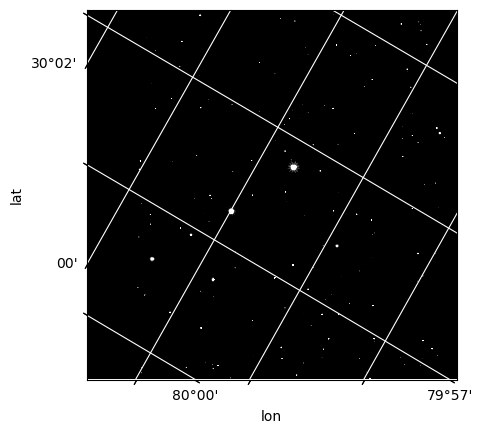

In [27]:
ax = plt.subplot(projection=image.meta.wcs)
plt.imshow(image.data.value, vmin=10, vmax=60, origin='lower')
plt.gray()
plt.grid(color='white', ls='solid')
ax.coords[0].set_format_unit(u.degree)
ax.coords[0].coord_wrap = 180 * u.deg

The WCS can be evaluated directly as a function or using the Shared WCS Interface methods

In [28]:
from gwcs.wcstools import grid_from_bounding_box

The `bounding_box` of a WCS object represents the range of input values over which the transforms are valid. Typically it is the full detector. By default, input values outside the `bounding box` return `NaN`s. 

In [29]:
w.bounding_box

ModelBoundingBox(
    intervals={
        x0: Interval(lower=-0.5, upper=4087.5)
        x1: Interval(lower=-0.5, upper=4087.5)
    }
    model=CompoundModel(inputs=('x0', 'x1'))
    order='C'
)

In [30]:
x, y = grid_from_bounding_box(w.bounding_box)

Evaluating the WCS object returns the numerical values of the result.

In [31]:
ra, dec = w(x, y)
print (ra, dec)

[[80.02119288 80.0211752  80.02115752 ... 79.94869851 79.94868071
  79.94866292]
 [80.02116305 80.02114536 80.02112768 ... 79.94866862 79.94865083
  79.94863303]
 [80.02113321 80.02111553 80.02109785 ... 79.94863873 79.94862094
  79.94860314]
 ...
 [79.89829499 79.89827723 79.89825947 ... 79.82561085 79.82559305
  79.82557525]
 [79.89826466 79.8982469  79.89822914 ... 79.82558048 79.82556268
  79.82554488]
 [79.89823432 79.89821656 79.8981988  ... 79.8255501  79.8255323
  79.8255145 ]] [[29.98087415 29.98084768 29.98082122 ... 29.8730034  29.87297708
  29.87295076]
 [29.98088907 29.98086261 29.98083614 ... 29.87301813 29.87299181
  29.8729655 ]
 [29.980904   29.98087753 29.98085106 ... 29.87303287 29.87300655
  29.87298023]
 ...
 [30.04229442 30.0422678  30.04224117 ... 29.93372872 29.93370222
  29.93367572]
 [30.04230956 30.04228294 30.04225631 ... 29.93374371 29.9337172
  29.9336907 ]
 [30.04232471 30.04229808 30.04227145 ... 29.93375869 29.93373219
  29.93370569]]


Using the Shared WCS interface methods returns a Python object of type astropy.coordinates.SkyCoord.

In [32]:
sky = w.pixel_to_world(x, y)

In [33]:
print(sky)

<SkyCoord (ICRS): (ra, dec) in deg
    [[(80.02119288, 29.98087415), (80.0211752 , 29.98084768),
      (80.02115752, 29.98082122), ..., (79.94869851, 29.8730034 ),
      (79.94868071, 29.87297708), (79.94866292, 29.87295076)],
     [(80.02116305, 29.98088907), (80.02114536, 29.98086261),
      (80.02112768, 29.98083614), ..., (79.94866862, 29.87301813),
      (79.94865083, 29.87299181), (79.94863303, 29.8729655 )],
     [(80.02113321, 29.980904  ), (80.02111553, 29.98087753),
      (80.02109785, 29.98085106), ..., (79.94863873, 29.87303287),
      (79.94862094, 29.87300655), (79.94860314, 29.87298023)],
     ...,
     [(79.89829499, 30.04229442), (79.89827723, 30.0422678 ),
      (79.89825947, 30.04224117), ..., (79.82561085, 29.93372872),
      (79.82559305, 29.93370222), (79.82557525, 29.93367572)],
     [(79.89826466, 30.04230956), (79.8982469 , 30.04228294),
      (79.89822914, 30.04225631), ..., (79.82558048, 29.93374371),
      (79.82556268, 29.9337172 ), (79.82554488, 29.9336907

Other useful methods include

`getting a transform between intermediate frames`

In [34]:
detector_to_v2v3 = w.get_transform('detector', 'v2v3')
print(detector_to_v2v3)

Model: CompoundModel
Inputs: ('x0', 'x1')
Outputs: ('y0', 'y1')
Model set size: 1
Expression: [0] & [1] | [2] & [3] | [4] | [5] & [6] | [7] | [8] & [9] | [10] & [11]
Components: 
    [0]: <Shift(offset=1.)>

    [1]: <Shift(offset=1.)>

    [2]: <Shift(offset=-2044.5)>

    [3]: <Shift(offset=-2044.5)>

    [4]: <Mapping((0, 1, 0, 1))>

    [5]: <Polynomial2D(5, c0_0=0., c1_0=0.11034133, c2_0=-0.00000003, c3_0=-0., c4_0=0., c5_0=-0., c0_1=0.00034168, c0_2=-0.00000001, c0_3=-0., c0_4=-0., c0_5=0., c1_1=0.00000014, c1_2=-0., c1_3=0., c1_4=0., c2_1=0., c2_2=-0., c2_3=-0., c3_1=0., c3_2=-0., c4_1=-0.)>

    [6]: <Polynomial2D(5, c0_0=0., c1_0=0.00031436, c2_0=0.00000007, c3_0=0., c4_0=0., c5_0=-0., c0_1=0.10828278, c0_2=0.00000021, c0_3=-0., c0_4=0., c0_5=0., c1_1=-0.00000002, c1_2=-0., c1_3=-0., c1_4=0., c2_1=-0., c2_2=-0., c2_3=0., c3_1=-0., c3_2=-0., c4_1=-0.)>

    [7]: <Mapping((0, 1, 0, 1))>

    [8]: <Polynomial2D(1, c0_0=0., c1_0=-0.5, c0_1=-0.8660254)>

    [9]: <Polynomial2D(1, c

`showing the coorindate frames in the WCS pipeline`

In [35]:
print(w.available_frames)

['detector', 'v2v3', 'world']


Retrieving the entire `forward` or `backward` transform

In [36]:
print(w.forward_transform)

Model: CompoundModel
Inputs: ('x0', 'x1')
Outputs: ('lon', 'lat')
Model set size: 1
Expression: [0] & [1] | [2] & [3] | [4] | [5] & [6] | [7] | [8] & [9] | [10] & [11] | [12] & [13] | [14] | [15] | [16]
Components: 
    [0]: <Shift(offset=1.)>

    [1]: <Shift(offset=1.)>

    [2]: <Shift(offset=-2044.5)>

    [3]: <Shift(offset=-2044.5)>

    [4]: <Mapping((0, 1, 0, 1))>

    [5]: <Polynomial2D(5, c0_0=0., c1_0=0.11034133, c2_0=-0.00000003, c3_0=-0., c4_0=0., c5_0=-0., c0_1=0.00034168, c0_2=-0.00000001, c0_3=-0., c0_4=-0., c0_5=0., c1_1=0.00000014, c1_2=-0., c1_3=0., c1_4=0., c2_1=0., c2_2=-0., c2_3=-0., c3_1=0., c3_2=-0., c4_1=-0.)>

    [6]: <Polynomial2D(5, c0_0=0., c1_0=0.00031436, c2_0=0.00000007, c3_0=0., c4_0=0., c5_0=-0., c0_1=0.10828278, c0_2=0.00000021, c0_3=-0., c0_4=0., c0_5=0., c1_1=-0.00000002, c1_2=-0., c1_3=-0., c1_4=0., c2_1=-0., c2_2=-0., c2_3=0., c3_1=-0., c3_2=-0., c4_1=-0.)>

    [7]: <Mapping((0, 1, 0, 1))>

    [8]: <Polynomial2D(1, c0_0=0., c1_0=-0.5, c0_1=-0.8

In [37]:
print(w.backward_transform)

Model: CompoundModel
Inputs: ('lon', 'lat')
Outputs: ('y0', 'y1')
Model set size: 1
Expression: [0] | [1] | [2] | [3] & [4] | [5] & [6] | [7] | [8] & [9] | [10] | [11] & [12] | [13] & [14] | [15] & [16]
Components: 
    [0]: <SphericalToCartesian()>

    [1]: <RotationSequence3D(angles=[ 79.92369591, -29.95727682,   0.        ,  -0.28910705,  -0.3647081 ])>

    [2]: <CartesianToSpherical()>

    [3]: <Scale(factor=3600.)>

    [4]: <Scale(factor=3600.)>

    [5]: <Shift(offset=-1312.94914525)>

    [6]: <Shift(offset=1040.78537268)>

    [7]: <Mapping((0, 1, 0, 1))>

    [8]: <Polynomial2D(1, c0_0=0., c1_0=-0.5, c0_1=-0.8660254)>

    [9]: <Polynomial2D(1, c0_0=0., c1_0=-0.8660254, c0_1=0.5)>

    [10]: <Mapping((0, 1, 0, 1))>

    [11]: <Polynomial2D(5, c0_0=0., c1_0=9.0628704, c2_0=0.00002545, c3_0=0.00000002, c4_0=-0., c5_0=0., c0_1=-0.02859496, c0_2=0.00000613, c0_3=0.00000001, c0_4=0., c0_5=0., c1_1=-0.00010773, c1_2=0.00000003, c1_3=-0., c1_4=-0., c2_1=-0.00000001, c2_2=0., c2_3

Other GWCS features include the ability to

- insert additional frames and transforms
- compute the inverse of the transforms using an iterative numerical method (in case an inverse transform is not provided)
- create  FITS approximation using the SIP convention to represent the distortion
- convert to other celestial frames usnig the `Shared API`
